In [9]:
import chromadb
import numpy as np

CHROMA_PATH = "../chroma_db"
client = chromadb.PersistentClient(path=CHROMA_PATH)

collection_train = client.get_collection(name="train_data")
collection_test = client.get_collection(name="test_data")



def load_data_from_chroma(collection):

    data = collection.get(include=['embeddings', 'metadatas'])
    
    embeddings = data['embeddings']
     
    labels = [item['label'] for item in data['metadatas']]
    
    return np.array(embeddings), np.array(labels)

X_train, y_train = load_data_from_chroma(collection_train)

X_test, y_test = load_data_from_chroma(collection_test)

print(f"\nX_train shape: {X_train.shape} (Features)")
print(f"y_train shape: {y_train.shape} (Labels)")


X_train shape: (120000, 384) (Features)
y_train shape: (120000,) (Labels)


In [10]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

In [14]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Get the class names for the plot later
classes = encoder.classes_.astype(str)
n_classes = len(classes)

print(f"Encoded classes: {classes}")

Encoded classes: ['0' '1' '2' '3']


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


# Logistic Regression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train_encoded)

# Random Forest
model_rf = RandomForestClassifier(n_estimators=50, random_state=42)
model_rf.fit(X_train, y_train_encoded)

# SVM 

# LinearSVC is fast, but doesn't give probabilities by default.
# We wrap it in CalibratedClassifierCV to get probabilities for the ROC curve.
svm_base = LinearSVC(dual='auto', random_state=42)
model_svm = CalibratedClassifierCV(svm_base)
model_svm.fit(X_train, y_train_encoded)

,estimator,LinearSVC(random_state=42)
,method,'sigmoid'
,cv,None
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'


In [13]:
from sklearn.metrics import accuracy_score, classification_report

# Predict
y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_svm = model_svm.predict(X_test)

# Accuracy Scores
acc_lr = accuracy_score(y_test_encoded, y_pred_lr)
acc_rf = accuracy_score(y_test_encoded, y_pred_rf)
acc_svm = accuracy_score(y_test_encoded, y_pred_svm)

print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print(f"Random Forest Accuracy:       {acc_rf:.4f}")
print(f"SVM Accuracy:                 {acc_svm:.4f}")


Logistic Regression Accuracy: 0.8893
Random Forest Accuracy:       0.8709
SVM Accuracy:                 0.8897


In [15]:

print("\n--- Detailed Report (Logistic Regression) ---")
print(classification_report(y_test_encoded, y_pred_lr, target_names=classes)) 

print("\n--- Detailed Report (Random Forest) ---")
print(classification_report(y_test_encoded, y_pred_rf, target_names=classes))

 
print("\n--- Detailed Report (SVM) ---")
print(classification_report(y_test_encoded, y_pred_svm, target_names=classes))


--- Detailed Report (Logistic Regression) ---
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1900
           1       0.95      0.96      0.96      1900
           2       0.84      0.85      0.85      1900
           3       0.87      0.85      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600


--- Detailed Report (Random Forest) ---
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1900
           1       0.92      0.94      0.93      1900
           2       0.83      0.82      0.83      1900
           3       0.85      0.84      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600


--- Detailed Report (SVM) ---
           

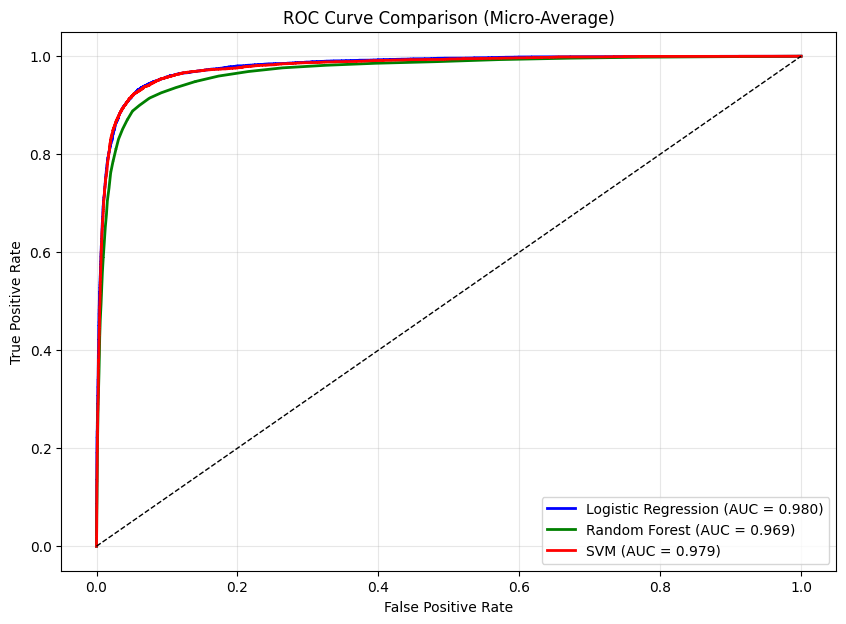

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- Probabilités des modèles ---
probs = {
    "Logistic Regression": model_lr.predict_proba(X_test),
    "Random Forest":        model_rf.predict_proba(X_test),
    "SVM":                  model_svm.predict_proba(X_test)
}

# Couleurs personnalisées
colors = {
    "Logistic Regression": "blue",
    "Random Forest": "green",
    "SVM": "red"
}

# --- Binarisation ---
y_bin = label_binarize(y_test_encoded, classes=[0, 1, 2, 3])

# --- ROC + AUC ---
roc_results = {}

for name, p in probs.items():
    fpr, tpr, _ = roc_curve(y_bin.ravel(), p.ravel())
    roc_results[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc(fpr, tpr)
    }

# --- Plot ---
plt.figure(figsize=(10, 7))

for name, res in roc_results.items():
    plt.plot(
        res["fpr"],
        res["tpr"],
        color=colors[name],              
        label=f"{name} (AUC = {res['auc']:.3f})",
        linewidth=2
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Micro-Average)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [20]:
from sklearn.metrics import accuracy_score

print("\n=== Vérification d'Overfitting ===")

# Accuracy sur train
train_acc = accuracy_score(y_train_encoded, model_lr.predict(X_train))

# Accuracy sur test
test_acc = acc_lr   # déjà calculé auparavant

print(f"Accuracy (Train) : {train_acc:.2%}")
print(f"Accuracy (Test)  : {test_acc:.2%}")

# Calcul du gap
gap = train_acc - test_acc
print(f"Écart (Train - Test) : {gap:.2%}")

# Interprétation
if gap > 0.05:
    print("  Le modèle montre possiblement un overfitting (écart > 5%).")
else:
    print("  Pas d’overfitting détecté : le modèle semble bien généraliser.")



=== Vérification d'Overfitting ===
Accuracy (Train) : 89.27%
Accuracy (Test)  : 88.93%
Écart (Train - Test) : 0.34%
  Pas d’overfitting détecté : le modèle semble bien généraliser.


In [21]:
import joblib

joblib.dump(model_lr, '../modele/news_classifier_logreg_modele.pkl')
joblib.dump(encoder, '../modele/label_encoder.pkl')

['../modele/label_encoder.pkl']